# Overfitting Problem 실습 (데이터 크기 차이)

이번 실습에서는 **데이터 크기 차이에 따른 Overfitting** 현상을 체감해봅니다.
- 작은 데이터셋 (100개 샘플)
- 큰 데이터셋 (2000개 샘플)
- 같은 복잡한 모델을 적용하여 비교
- 학습 곡선을 통해 Overfitting 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. 데이터 준비 (작은 데이터셋 vs 큰 데이터셋)

In [2]:
# 작은 데이터셋 (100개)
X_small, y_small = make_moons(n_samples=100, noise=0.25, random_state=42)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# 큰 데이터셋 (2000개)
X_large, y_large = make_moons(n_samples=2000, noise=0.25, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_large, y_large, test_size=0.3, random_state=42)

# 스케일링
scaler_s = StandardScaler()
X_train_s = scaler_s.fit_transform(X_train_s)
X_test_s = scaler_s.transform(X_test_s)

scaler_l = StandardScaler()
X_train_l = scaler_l.fit_transform(X_train_l)
X_test_l = scaler_l.transform(X_test_l)

## 2. 복잡한 모델 정의

In [3]:
def build_complex_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(2,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. 작은 데이터셋 학습

In [4]:
model_small = build_complex_model()
history_small = model_small.fit(
    X_train_s, y_train_s, validation_data=(X_test_s, y_test_s),
    epochs=100, batch_size=16, verbose=0
)

## 4. 큰 데이터셋 학습

In [5]:
model_large = build_complex_model()
history_large = model_large.fit(
    X_train_l, y_train_l, validation_data=(X_test_l, y_test_l),
    epochs=100, batch_size=16, verbose=0
)

## 5. 학습 결과 비교 시각화

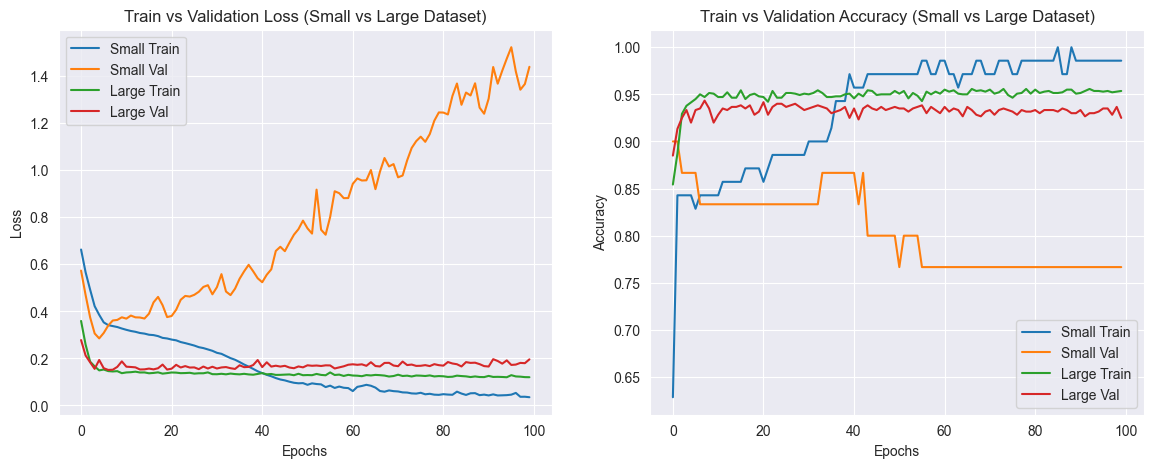

In [6]:
plt.figure(figsize=(14,5))

# Loss 비교
plt.subplot(1,2,1)
plt.plot(history_small.history["loss"], label="Small Train")
plt.plot(history_small.history["val_loss"], label="Small Val")
plt.plot(history_large.history["loss"], label="Large Train")
plt.plot(history_large.history["val_loss"], label="Large Val")
plt.title("Train vs Validation Loss (Small vs Large Dataset)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy 비교
plt.subplot(1,2,2)
plt.plot(history_small.history["accuracy"], label="Small Train")
plt.plot(history_small.history["val_accuracy"], label="Small Val")
plt.plot(history_large.history["accuracy"], label="Large Train")
plt.plot(history_large.history["val_accuracy"], label="Large Val")
plt.title("Train vs Validation Accuracy (Small vs Large Dataset)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 6. 생각해보기
- Overfitting은 언제 발생하는가?
- 데이터셋 크기가 모델 성능에 미치는 영향은?